In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import warnings
import os
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

In [2]:
df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv', index_col=0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [3]:
df.shape

(200, 4)

In [4]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [5]:
df.dtypes

Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [6]:
df.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [7]:
plt.style.use('fivethirtyeight')

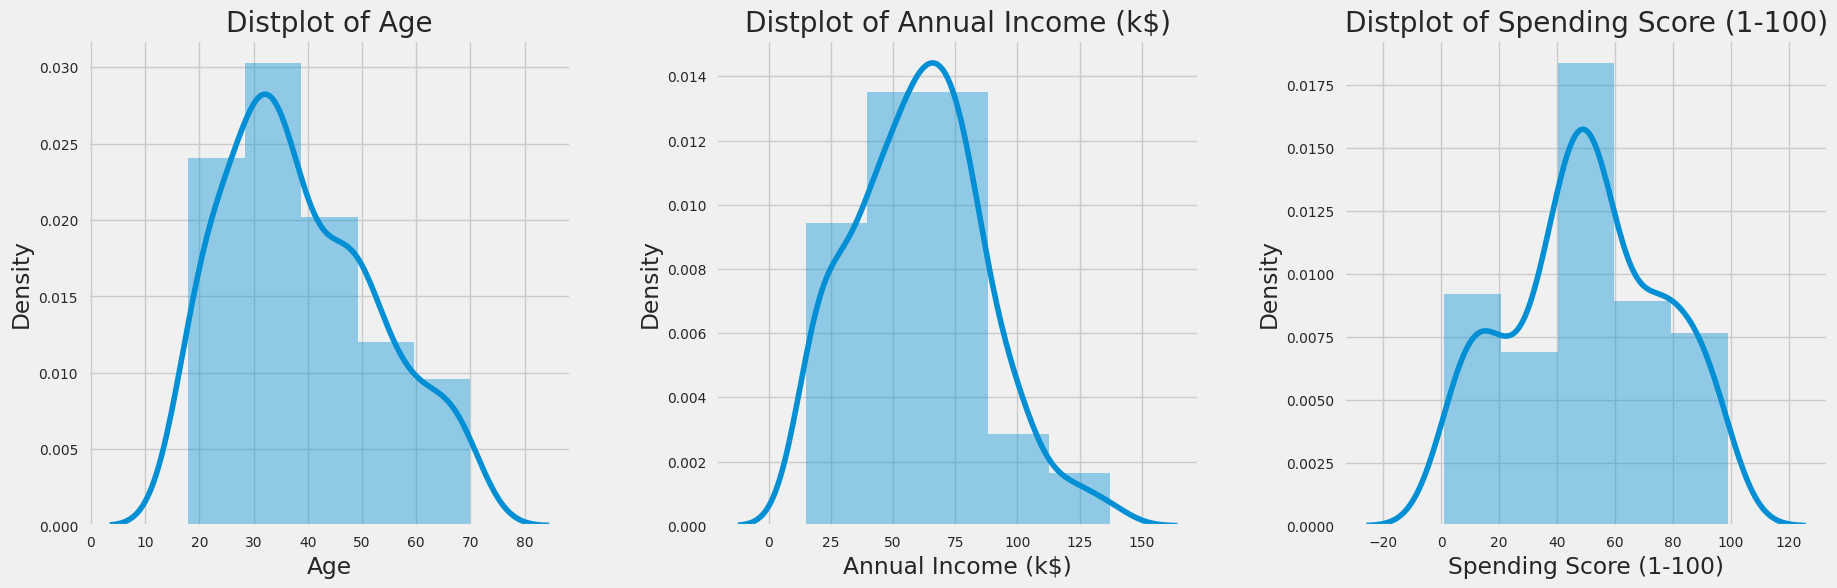

In [8]:
plt.figure(1 , figsize = (20 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.3 , wspace = 0.3)
    sns.distplot(df[x] , bins = 5)
    plt.title('Distplot of {}'.format(x))
plt.show()

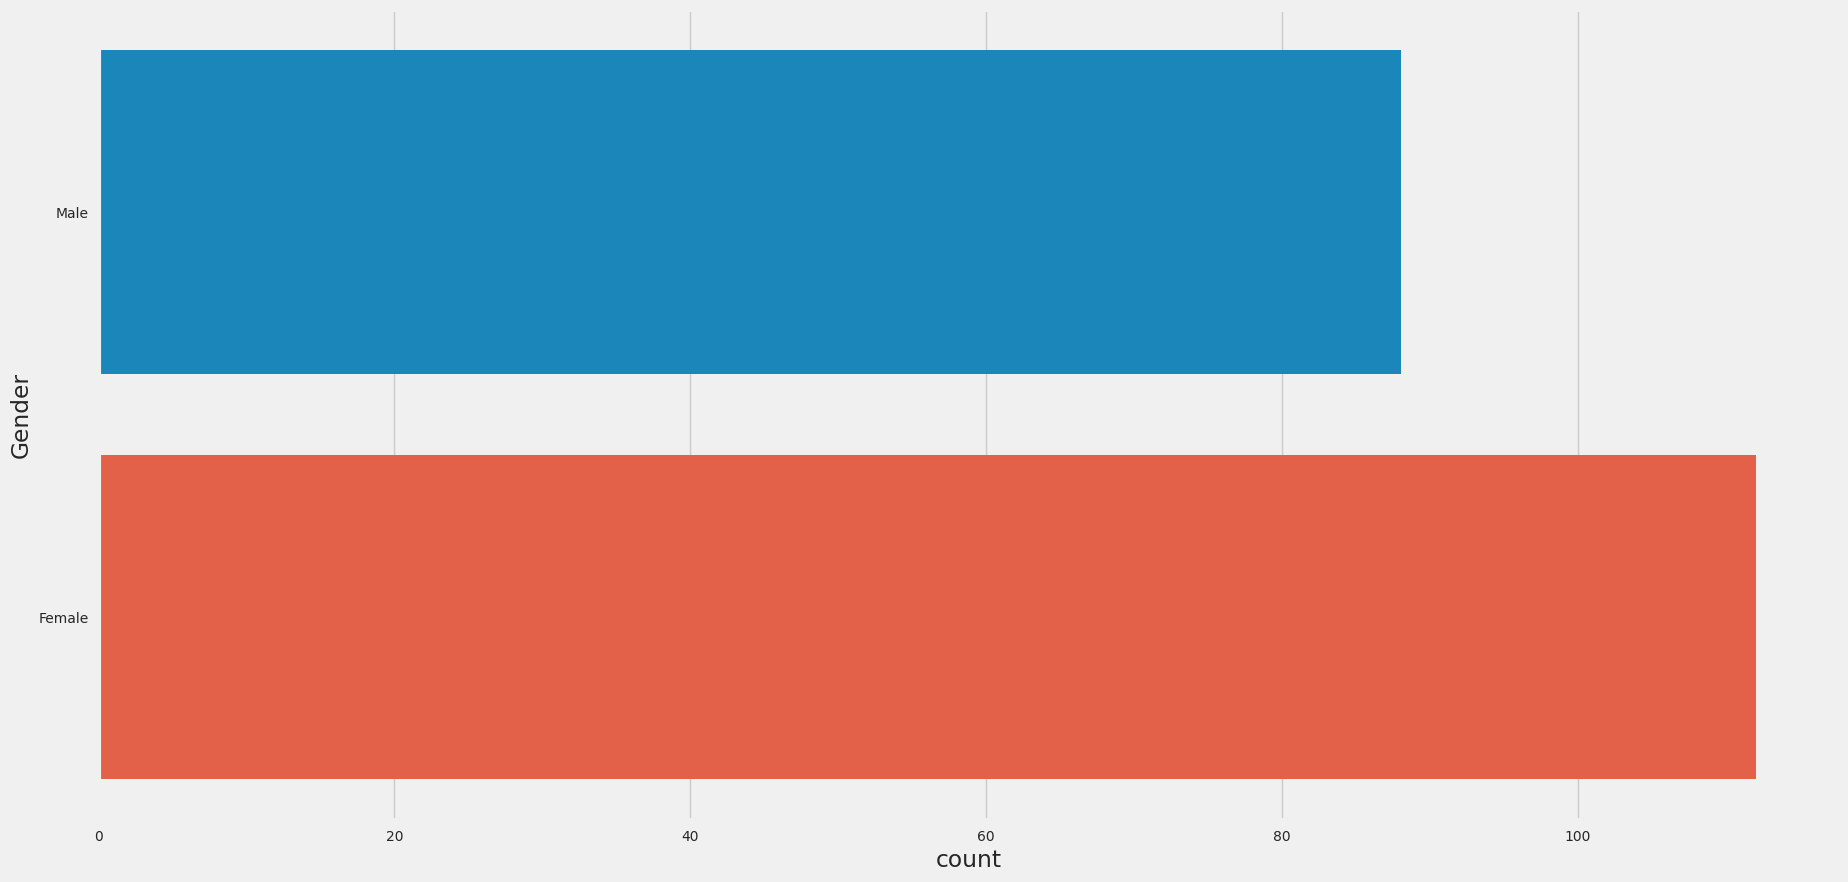

In [9]:
plt.figure(1 , figsize = (20 , 10))
sns.countplot(y = 'Gender' , data = df)
plt.show()

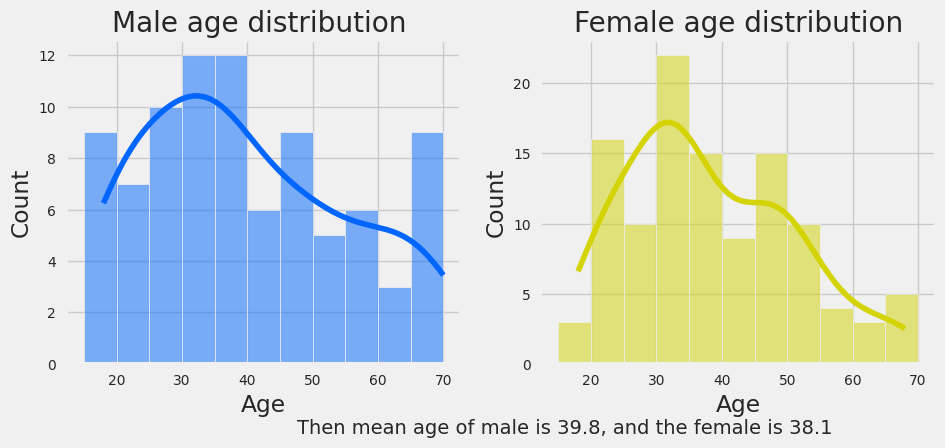

In [10]:
# Distribution of age with respect to gender
male = df[df.Gender == "Male"]["Age"]
female = df[df.Gender != "Male"]['Age']

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
sns.histplot(male, color='#0066ff', bins = range(15,75,5), kde = True)
plt.title("Male age distribution ")

plt.subplot(1,2,2)
sns.histplot(female, color = '#D4D404', bins = range(15,75,5), kde = True)
plt.title("Female age distribution");
plt.text(-25,-5,f"Then mean age of male is {round(male.mean(),1)}, and the female is {round(female.mean(),1)}")

plt.show()

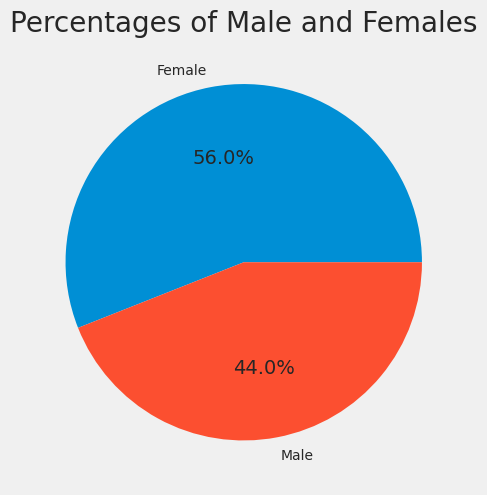

In [11]:
plt.pie(df.Gender.value_counts(), labels = ['Female', 'Male'], autopct ="%.01f%%")
plt.title('Percentages of Male and Females' );

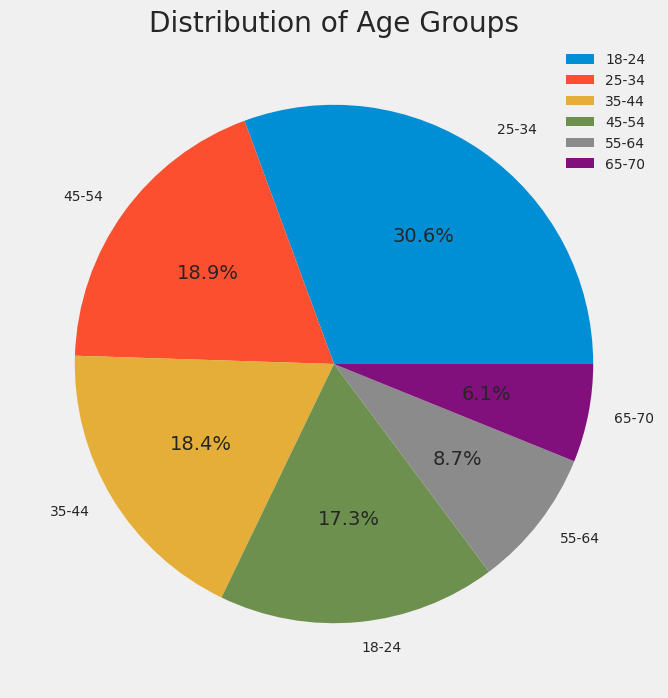

In [12]:
# Spending Score by age group

df['Age_Group'] = pd.cut(df.Age, bins = [18, 25, 35, 45, 55, 65, 70], labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-70'])

plt.figure(figsize = (8, 8))
plt.pie(df.Age_Group.value_counts(), labels = df.Age_Group.value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of Age Groups')
plt.legend(['18-24', '25-34', '35-44', '45-54', '55-64', '65-70'])
plt.show()

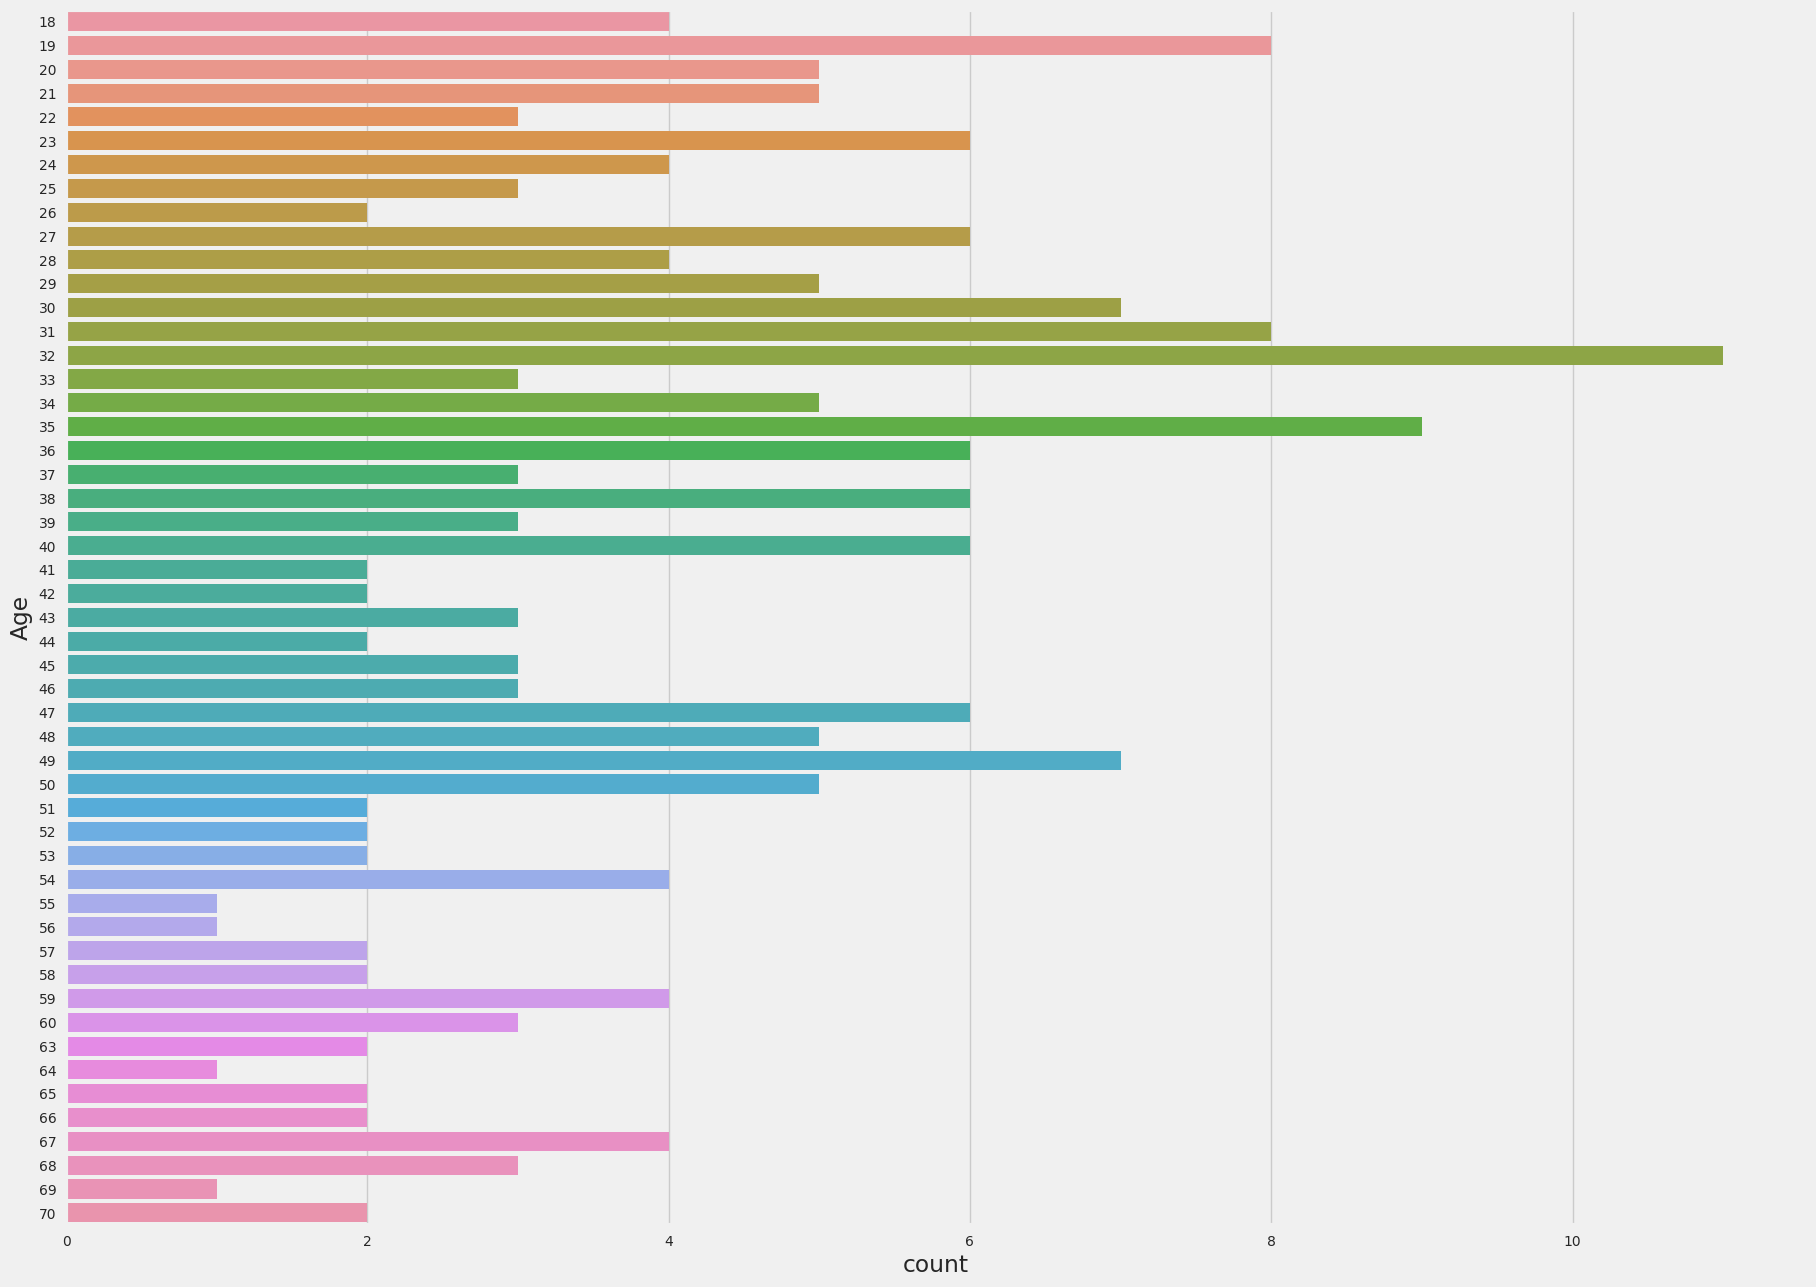

In [13]:
plt.figure(1 , figsize = (20 , 15))
sns.countplot(y = 'Age' , data = df)
plt.show()

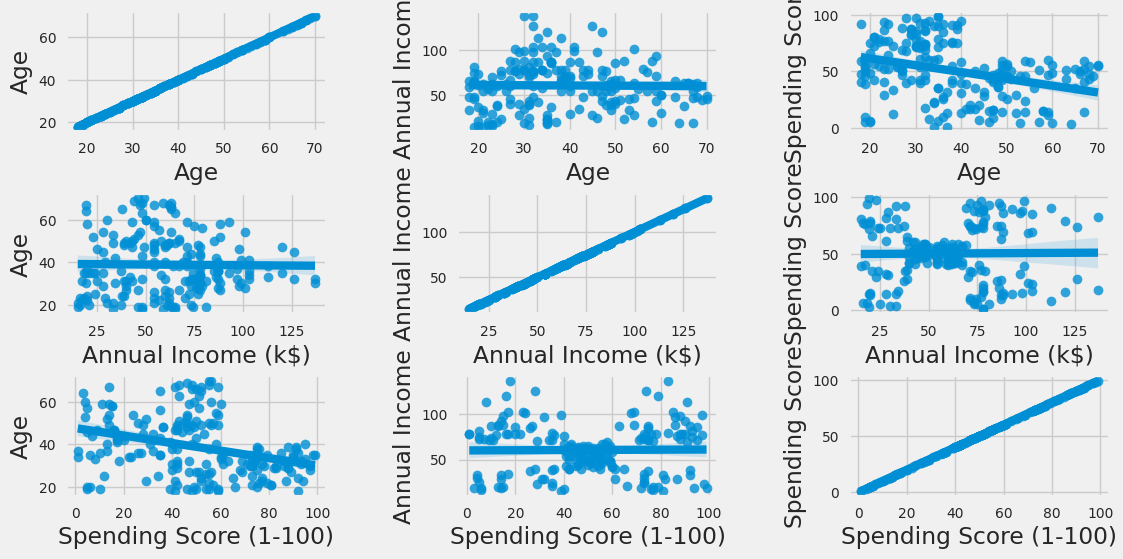

In [14]:
plt.figure(1 , figsize = (12 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    for y in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
        n += 1
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()

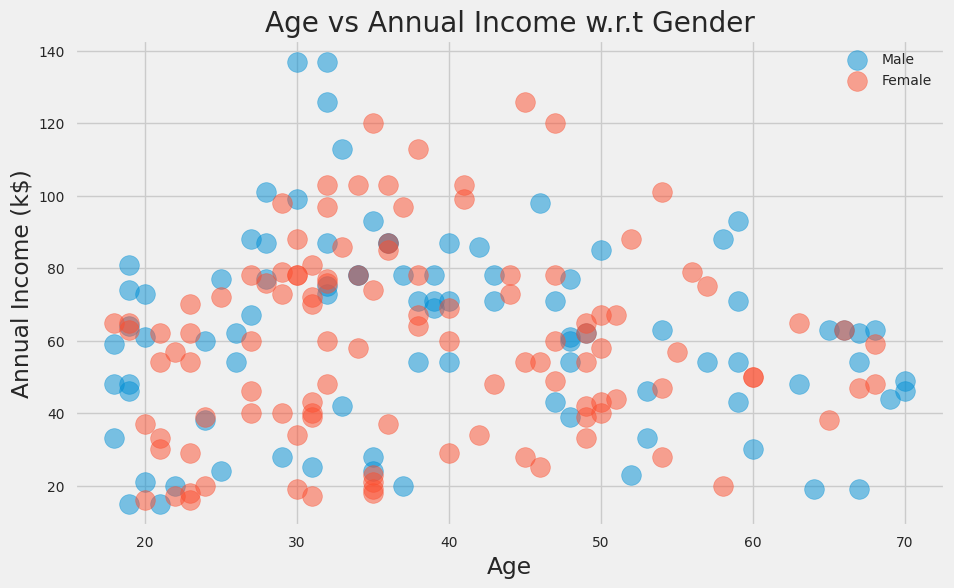

In [15]:
plt.figure(1 , figsize = (10 , 6))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Age' , y = 'Annual Income (k$)' , data = df[df['Gender'] == gender] ,
                s = 200 , alpha = 0.5 , label = gender)
plt.xlabel('Age'), plt.ylabel('Annual Income (k$)') 
plt.title('Age vs Annual Income w.r.t Gender')
plt.legend()
plt.show()

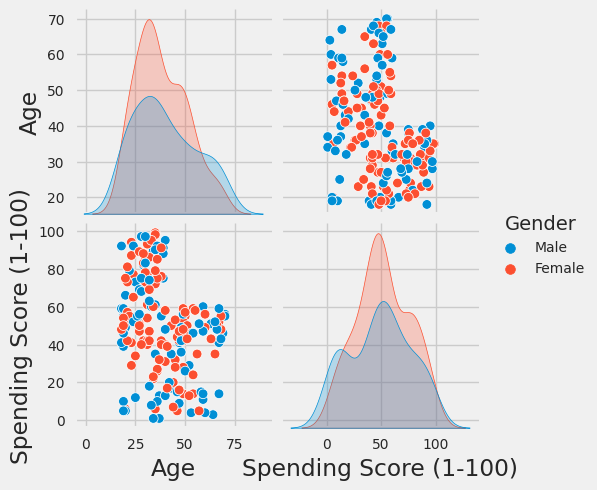

In [16]:
sns.pairplot(df.drop("Annual Income (k$)", axis = 1), hue = "Gender");

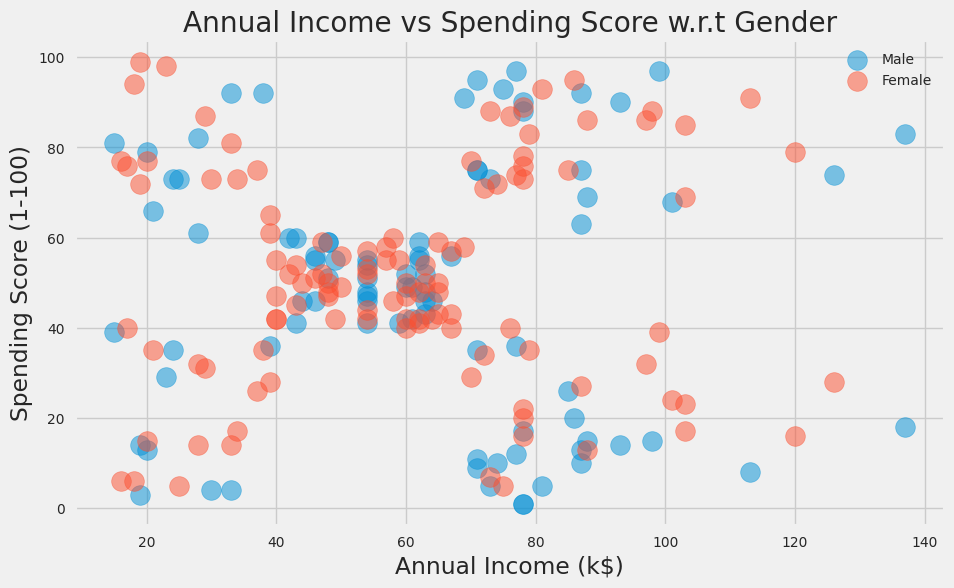

In [17]:
plt.figure(1 , figsize = (10 , 6))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Annual Income (k$)',y = 'Spending Score (1-100)' ,
                data = df[df['Gender'] == gender] ,s = 200 , alpha = 0.5 , label = gender)
plt.xlabel('Annual Income (k$)'), plt.ylabel('Spending Score (1-100)') 
plt.title('Annual Income vs Spending Score w.r.t Gender')
plt.legend()
plt.show()

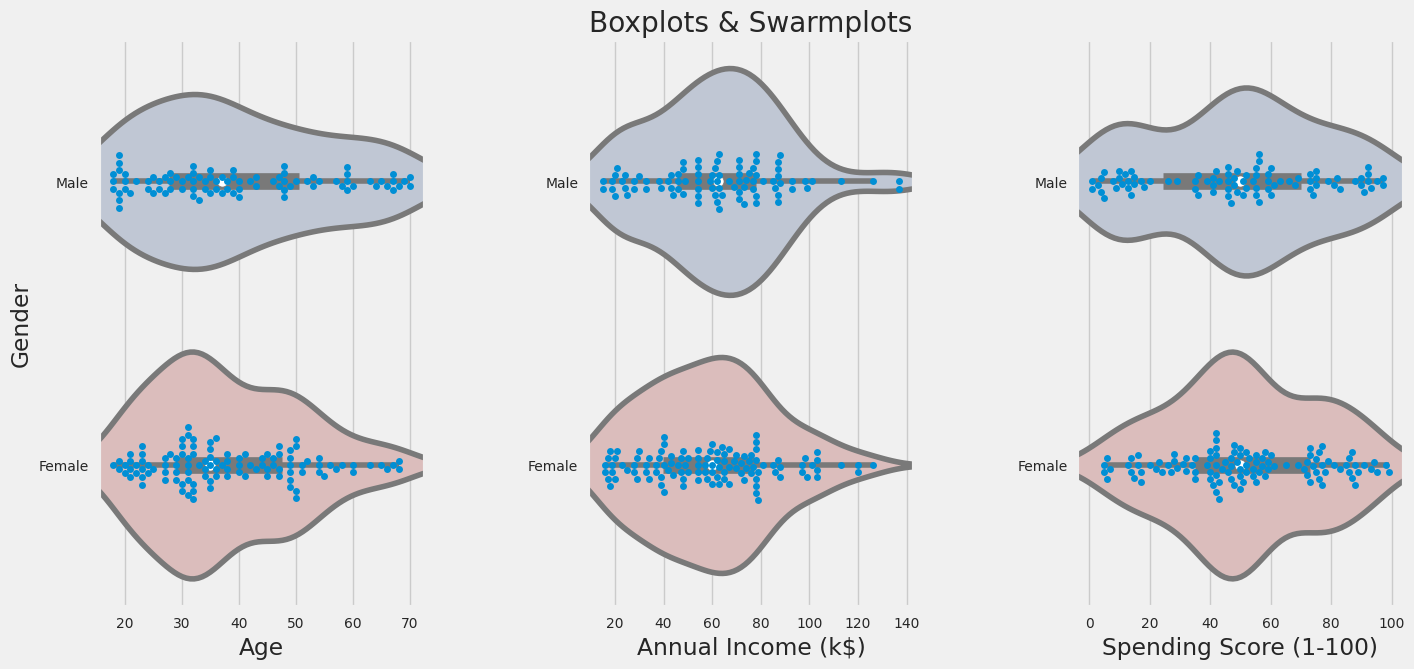

In [18]:
plt.figure(1 , figsize = (15 , 7))
n = 0 
for cols in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1 
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.violinplot(x = cols , y = 'Gender' , data = df , palette = 'vlag')
    sns.swarmplot(x = cols , y = 'Gender' , data = df)
    plt.ylabel('Gender' if n == 1 else '')
    plt.title('Boxplots & Swarmplots' if n == 2 else '')
plt.show()

In [19]:
'''Age and spending Score'''
X1 = df[['Age' , 'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

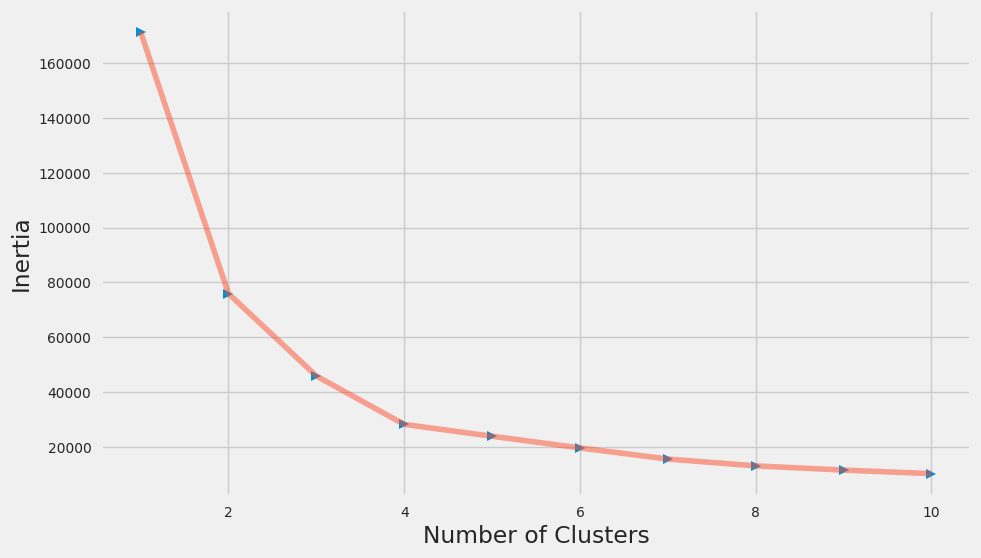

In [20]:
plt.figure(1 , figsize = (10 ,6))
plt.plot(np.arange(1 , 11) , inertia , '>')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [21]:
algorithm = (KMeans(n_clusters = 6 ,init='k-means++', n_init = 10 ,max_iter=800, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [22]:
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

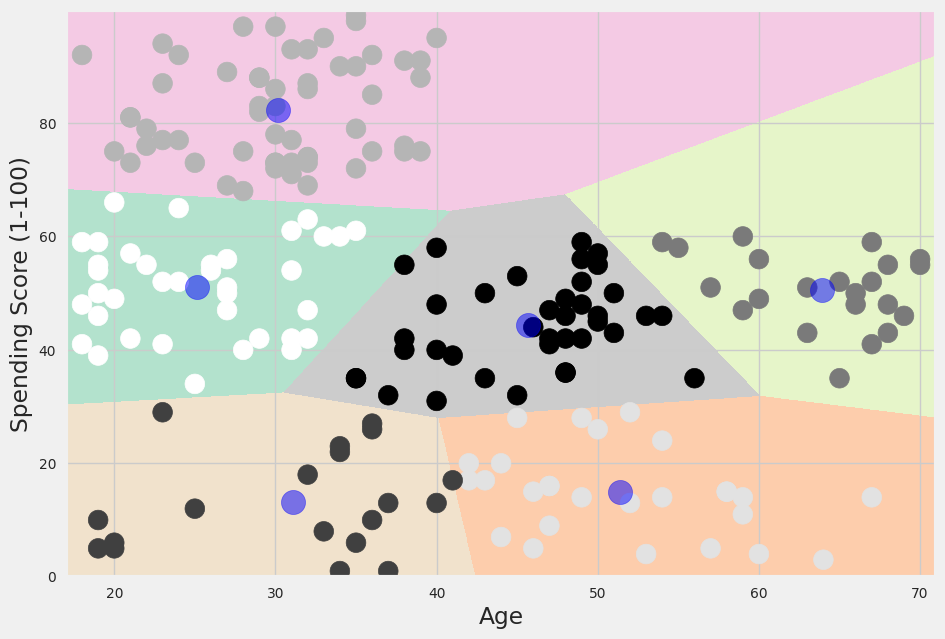

In [23]:
plt.figure(1 , figsize = (10 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Age' ,y = 'Spending Score (1-100)' , data = df , c = labels1 , 
            s = 200 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'blue' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Age')
plt.show()

In [24]:
'''Annual Income and spending Score'''
X2 = df[['Annual Income (k$)' , 'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)

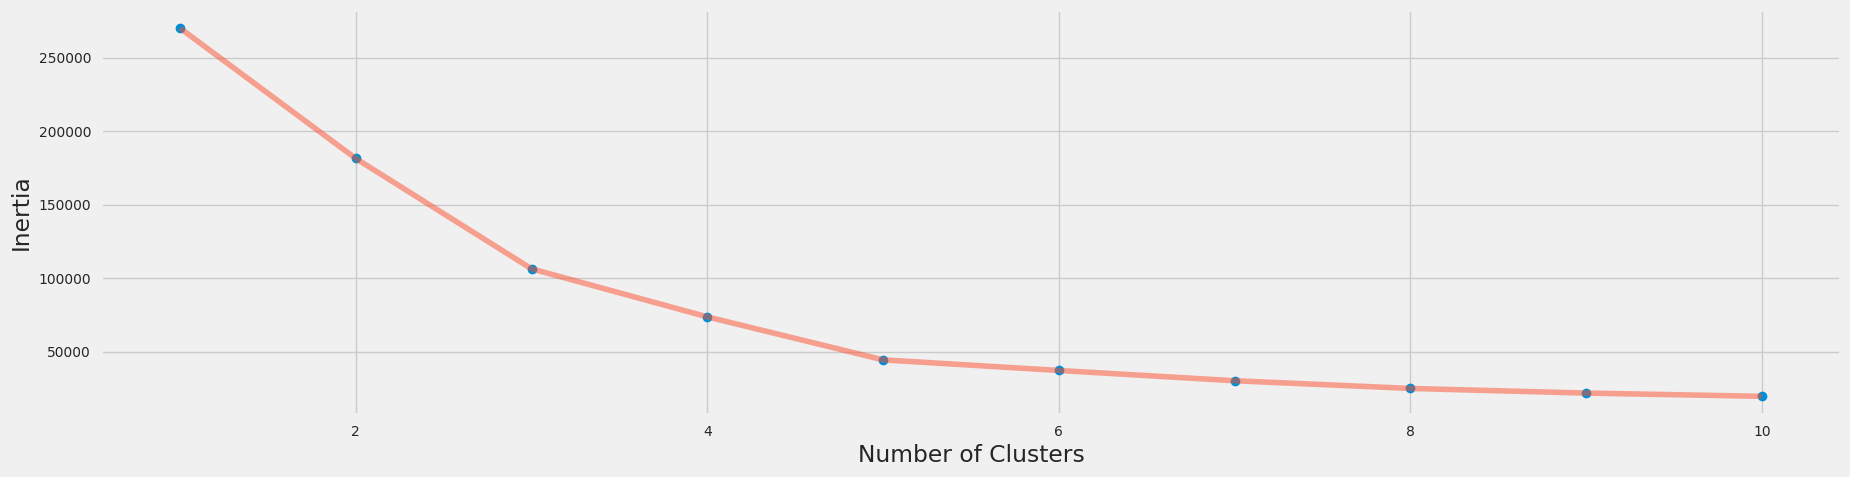

In [25]:
plt.figure(1 , figsize = (20 ,5))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [26]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X2)
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

In [27]:
h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z2 = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

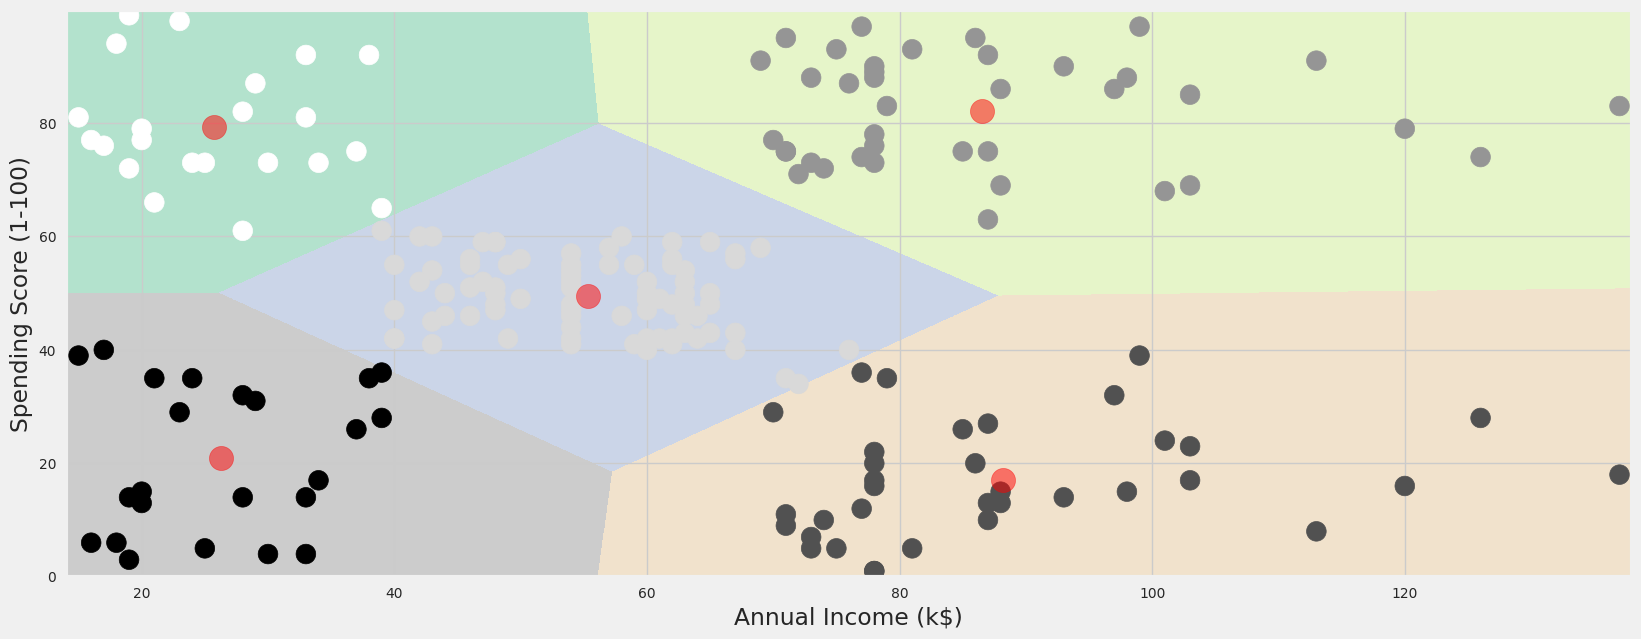

In [28]:
plt.figure(1 , figsize = (18 , 7) )
plt.clf()
Z2 = Z2.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Annual Income (k$)' ,y = 'Spending Score (1-100)' , data = df , c = labels2 , 
            s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Annual Income (k$)')
plt.show()

In [29]:
X3 = df[['Age' , 'Annual Income (k$)' ,'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X3)
    inertia.append(algorithm.inertia_)

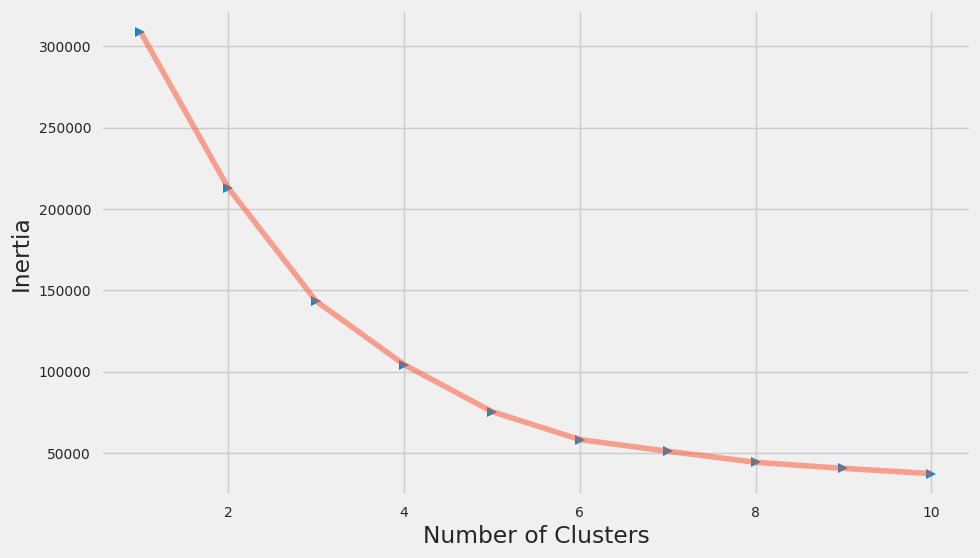

In [30]:
plt.figure(1 , figsize = (10 ,6))
plt.plot(np.arange(1 , 11) , inertia , '>')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [31]:
algorithm = (KMeans(n_clusters = 8 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X3)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_

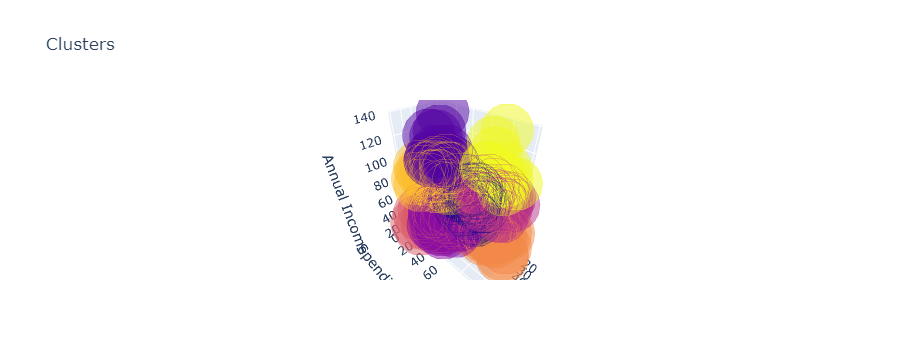

In [32]:
df['label3'] =  labels3
trace1 = go.Scatter3d(
    x= df['Age'],
    y= df['Spending Score (1-100)'],
    z= df['Annual Income (k$)'],
        mode='markers',
     marker=dict(
        color = df['label3'], 
        size= 30,
        line=dict(
            color= df['label3'],
            width= 12
        ),
        opacity=0.5
     )
)
data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Age'),
            yaxis = dict(title  = 'Spending Score'),
            zaxis = dict(title  = 'Annual Income'),
                    )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)